### this is for 2d

In [113]:
# importing modules

import numpy as np
import os
import skimage.io as io
import skimage
from tqdm import tqdm
import scipy as sp
import time
import scipy.io as sio
import hdf5storage
from multiprocessing import TimeoutError
from multiprocessing.pool import ThreadPool as Pool
from functools import partial
import matplotlib.pyplot as plt
from aicspylibczi import CziFile
from natsort import natsorted
import warnings
warnings.filterwarnings("ignore")

from utils import *

In [120]:
# pick data file to work with & load data

vid_type = "processed"
num = 6

img = get_file(vid_type, num)

shape = img.size
num_timepoints, num_stacks, height, width = shape[1], shape[3], shape[4], shape[5]

Loading dicty_factin_pip3-06_processed.czi with dims [{'X': (0, 475), 'Y': (0, 2048), 'Z': (0, 114), 'C': (0, 2), 'T': (0, 241), 'S': (0, 1)}]


### smoothing

In [121]:
def smoothing(k, img):
    print(k)
    def pre_processing(frm_id, image, ch_id):
        img = []
        for z in range(z_slice_start,z_slice_end+1):
            img_temp = image.read_image(T=frm_id, C=ch_id, Z=z)
            img.append(np.squeeze(img_temp[0]))
            
        img = np.stack(img, axis=0)
        return img

    current_frame = pre_processing(k, img, channel)

    if k == start_frame or k == end_frame - jump:
        result = current_frame
    else:
        previous_frame = pre_processing(k - jump, img, channel)
        next_frame = pre_processing(k + jump, img, channel)

        if k == start_frame + jump or k == end_frame - 2*jump:
            result = np.average([previous_frame, current_frame, next_frame], weights=kernel1, axis=0)

        else:
            frame_minus_2_jump = pre_processing(k - 2 * jump, img, channel)
            result = np.average([frame_minus_2_jump, previous_frame, current_frame, next_frame], weights=kernel2, axis=0)

    result = result.astype(np.float32)
    np.save(os.path.join(f'{smooth_address}', f'{k}'), result)

# define these
jump = 1
start_frame = 0
end_frame = num_timepoints
channel = 0
z_slice_start = 50
z_slice_end = 52

# create folder for storing smoothed frames
smooth_address = os.path.join('smoothed_frames',f'{vid_type}{num}')
os.makedirs(smooth_address, exist_ok=True)

In [123]:
# smooth frames w/ multithreading
# TO-DO: fix pickle issue...

kernel1 = np.array([0.225,0.55,0.225]);
kernel2 = np.array([0.036,0.249,0.431,0.249])

numProcessors = 8   # maybe change it to 8 (but that's it!)
pool = Pool(processes=numProcessors)

print('Post-processing in parallel with '+str(numProcessors)+' processors')

# store start time
stopwatchStart = time.time()
pool.map(partial(smoothing, img = img), range(num_timepoints-1))

print('Wall time = '+str(np.round(time.time() - stopwatchStart,2))+' s')

print('Parallel post processing complete, switching to serial')
pool.close()

Post-processing in parallel with 8 processors


TypeError: cannot pickle '_io.BufferedReader' object

In [124]:
# just run this when pool won't run bc pickle, might take a while ..

for k in range(start_frame, end_frame):
    smoothing(k, img)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240


### optical flow

In [125]:
# Lucas-Kanade method for Optical Flow
# INPUTS:

#k: Timeframe index, input_image: temporally smoothed movie
#sig: Spread of the Gaussian weights around a pixel, #thresh: Threshold for reliability score

# OUTPUTS (stored in a data file):
#vx: x-velocity, vy: y-velocity, vz: z-velocity
#reliabMat: reliability score for velocities calculated at a pixel (higher the better)

def LKxOptFlow(k,sig,thresh):
    print(k)
    def reliability_from_cubic_roots(a,b,c,d,e,f):
        trA = a + b + c;
        q = trA/3;
        x = (a + b - 2*c)**2/9 + (a -2*b + c)**2/9 + (b - 2*a + c)**2/9 + 2*(d**2 + e**2 + f**2);
        p = np.sqrt(x/6)
        detB = ((a-q)*(b-q)*(c-q) + 2*d*e*f - (a-q)*f**2 - (b-q)*e**2 - (c-q)*d**2)/(p**3)
        detB[detB > 2] = 2;
        detB[detB < -2] = -2;

        theta = np.arccos(detB/2)/3

        # define roots
        r1 = 2*np.cos(theta);
        r2 = 2*np.cos(theta + 2*np.pi/3);
        r3 = 2*np.cos(theta + 4*np.pi/3);

        # define eigs
        b1 = r1*p + q;
        b2 = r2*p + q;
        b3 = r3*p + q;

        # define reliability
        rel = np.stack((b1,b2,b3), axis=3)
        rel = np.min(rel, axis=3)
        return rel


    current_frame = np.load(smooth_address+'/{}.npy'.format(k))             # Load temporally smoothed frame-1
    next_frame = np.load(smooth_address+'/{}.npy'.format(k+1))         # Load temporally smoothed frame-2

    # Calculating the spatial and temporal gradients assuming the input frame is of the shape (ZYX)

    dy = np.gradient(current_frame,axis=1,edge_order=1)
    dx = np.gradient(current_frame,axis=2,edge_order=1)
    dz = np.gradient(current_frame,axis=0,edge_order=1)
    dt = next_frame - current_frame

    dz = dz.astype(np.float32); dy = dy.astype(np.float32); dx = dx.astype(np.float32); dt = dt.astype(np.float32);

    wdx2 = sp.ndimage.gaussian_filter(dx**2, sig, mode='nearest')
    wdy2 = sp.ndimage.gaussian_filter(dy**2, sig, mode='nearest')
    wdz2 = sp.ndimage.gaussian_filter(dz**2, sig, mode='nearest')

    wdxy = sp.ndimage.gaussian_filter(dx*dy, sig, mode='nearest')
    wdxz = sp.ndimage.gaussian_filter(dx*dz, sig, mode='nearest')
    wdyz = sp.ndimage.gaussian_filter(dy*dz, sig, mode='nearest')

    wdtx = sp.ndimage.gaussian_filter(dx*dt, sig, mode='nearest')
    wdty = sp.ndimage.gaussian_filter(dy*dt, sig, mode='nearest')
    wdtz = sp.ndimage.gaussian_filter(dz*dt, sig, mode='nearest')

    # Calculate Flow
    eps = 1e-6
    determinant = wdx2*wdy2*wdz2 + 2*wdxy*wdyz*wdxz - wdx2*(wdyz**2) - wdy2*(wdxz**2) - wdz2*(wdxy**2)

    vx = -((determinant + eps)**(-1))* ( \
              wdtx*(wdy2*wdz2 - wdyz**2) \
            + wdty*(wdxz*wdyz - wdxy*wdz2) \
            + wdtz*(wdxy*wdyz - wdxz*wdy2) );
    vy = -((determinant + eps)**(-1))* ( \
              wdtx*(wdxz*wdyz - wdxy*wdz2) \
            + wdty*(wdx2*wdz2 - wdxz**2) \
            + wdtz*(wdxy*wdxz - wdx2*wdyz) );
    vz = -((determinant + eps)**(-1))* ( \
              wdtx*(wdxy*wdyz - wdxz*wdy2) \
            + wdty*(wdxy*wdxz - wdx2*wdyz) \
            + wdtz*(wdx2*wdy2 - wdxy**2) );
    reliabMat = reliability_from_cubic_roots(wdx2,wdy2,wdz2,wdxy,wdxz,wdyz)

    vx = vx*(reliabMat > thresh);
    vy = vy*(reliabMat > thresh);
    vz = vz*(reliabMat > thresh);

    np.savez(of_address+'/{}.npz'.format(k), vx = vx,vy = vy,rel=reliabMat)   # to save as numpy data files
#    sio.savemat(of_address+'\\{}.mat'.format(k),{'vx':vx,'vy':vy,'vz':vz,'rel':reliabMat},do_compression=False) # to save as .MAT files
    return [0]

# Example usage:

of_address = os.path.join('opticalflow', f'{vid_type}{num}')                 # Create a local folder for storing OF results
os.makedirs(of_address,exist_ok=True)

file_list = natsorted(os.listdir(smooth_address))    # sort the image files numerically by frame-index
n_frames = len(file_list);

In [126]:
# compute optical flows w/ multithreading

numProcessors = 2   # maybe change it to 8 (but that's it)
pool = Pool(processes=numProcessors)

print('Post-processing in parallel with '+str(numProcessors)+' processors')

#store start time
stopwatchStart = time.time()
pool.map(partial(LKxOptFlow, sig = 2, thresh = 0.1), range(n_frames-1))

print('Wall time = '+str(np.round(time.time() - stopwatchStart,2))+' s')

print('Parallel post processing complete, switching to serial')
pool.close()

030

Post-processing in parallel with 2 processors
1
31
2
32
3
33
4
34
5
35
6
36
7
37
8
38
9
39
10
40
11
41
12
42
13
43
14
44
15
45
16
46
17
47
18
48
19
49
20
50
21
51
22
52
23
53
24
54
25
55
26
56
27
57
28
58
29
59
60
90
61
91
62
92
63
93
64
94
65
95
66
96
67
97
68
98
69
99
70
100
71
101
72
102
73
103
74
104
75
105
76
106
77
107
78
108
79
109
80
110
81
111
82
112
83
113
84
114
85
115
86
116
87
117
88
118
89
119
120
150
121
151
122
152
123
153
124
154
125
155
126
156
127
157
128
158
129
159
130
160
131
161
132
162
133
163
134
164
135
165
136
166
137
167
138
168
139
169
140
170
141
171
142
172
143
173
144
174
145
175
146
176
147
177
148
178
149
179
180
210
181
211
182
212
183
213
184
214
185
215
186
216
187
217
188
218
189
219
190
220
191
221
192
222
193
223
194
224
195
225
196
226
197
227
198
228
199
229
200
230
201
231
202
232
203
233
204
234
205
235
206
236
207
237
208
238
209
239
Wall time = 653.3 s
Parallel post processing complete, switching to serial


(145920000,)


(-1.0, 1.0)

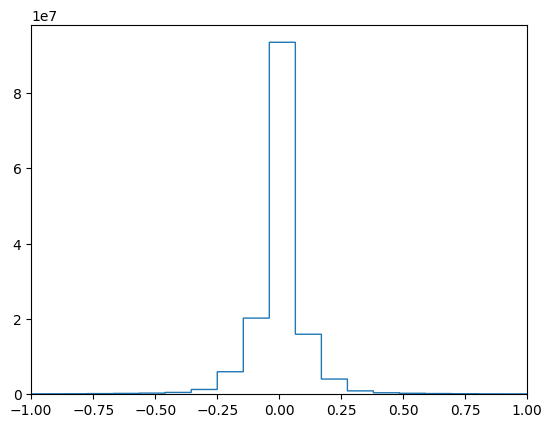

In [52]:
# plot a histogram of vectors in one direction

file_list = natsorted(os.listdir(of_address))    # sort the image files numerically by frame-index
n_frames = 50 #len(file_list)

# returns the velocity magnitude at every point as a list
# direction is either 'vx' or 'vy'
def one_direction_vel(direction):
    list = []
    for k in range(n_frames):
        with np.load(of_address+'/{}.npz'.format(k)) as frame:
            a = frame[direction]
            list.append(a.flatten())
    return list

vx = np.array(one_direction_vel('vx')).flatten()

print(vx.shape)
counts, bins = np.histogram(vx,800)
plt.stairs(counts, bins)
plt.xlim(-1, 1)

In [ ]:
# TO DO: OF visualization
# see below.. need to migrate to here and clean up

### centroid prediction

In [ ]:
img_temp = img.read_image(C=channel, Z=z_slice_start)
img_temp = scale_img(img_temp[0].squeeze())
mask = binarize_video(img_temp)

In [108]:
# first, some useful functions

# get cells in a single 2d frame
def get_cells(img, masked):
    bboxes, num_cells, cell_areas = bounding_boxes(masked)
    zoomed_cells = []
    relative_centroids = []
    for box in bboxes:
        zoomed_cells.append([img[box[0]:box[2],box[1]:box[3]]])
        relative_centroids.append(skimage.measure.centroid(masked[box[0]:box[2],box[1]:box[3]]))
        
    return zoomed_cells, bboxes, num_cells, cell_areas, relative_centroids, masked

# compute the average OF vector in each cell
def avg_of(of, bboxes, masked, cell_areas):
    vx = of['vx'][0]
    vy = of['vy'][0]
    avg_ofs = []
    for box, area in zip(bboxes, cell_areas):
        mask = masked[box[0]:box[2],box[1]:box[3]]
        mask[mask != 0] = 1
        vx_cell = vx[box[0]:box[2],box[1]:box[3]] * mask
        vy_cell = vy[box[0]:box[2],box[1]:box[3]] * mask
        avg_ofs.append([np.sum(vx_cell)/area, np.sum(vy_cell)/area])
    return avg_ofs

In [109]:
# "predicts" (more like calculate) the centroid of the next frame
# this is more or less a baseline
def predict_centroid(k, img):
    print(k)
    
    img_curr = img.read_image(T=k, C=channel, Z=z_slice_start)
    img_curr = scale_img(img_curr[0].squeeze())

    zoomed_cells, bboxes, num_cells, cell_areas, relative_centroids, masked = get_cells(img_curr, mask[k])

    of = np.load(of_address+'/{}.npz'.format(k))
    avg_ofs = avg_of(of, bboxes, masked, cell_areas)

    predictions = []
    for v, box, o in zip(avg_ofs, bboxes, relative_centroids):
        abs_centroid = np.array([box[0] + o[0], box[1] + o[1]])
        predictions.append(abs_centroid + 2*np.array(v))

    # loss
    img_next = img.read_image(T=k+2, C=channel, Z=z_slice_start)
    img_next = scale_img(img_next[0].squeeze())
    zoomed_cells, bboxes, num_cells, cell_areas, relative_centroids, masked = get_cells(img_next, mask[k+2])
    actual = []
    for box, o in zip(bboxes, relative_centroids):
        actual.append(np.array([box[0] + o[0], box[1] + o[1]]))

    return predictions, actual

In [110]:
predictions = np.array([[0,0]])
actual = np.array([[0,0]])
for k in range(0,29):
    out = predict_centroid(k, img)
    if out:
        predictions = np.vstack((predictions, out[0]))
        actual = np.vstack((actual, out[1]))

predictions = predictions[1:]
actual = actual[1:]

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28


In [111]:
s = 0
for hat, real in zip(predictions, actual):
    s += ((hat[0] - real[0])**2 + (hat[1] - real[1])**2)**(1/2)
print(s/len(predictions))
print(len(predictions))

796.5152698107339
180


In [112]:
for p, a in zip(predictions, actual):
    print(p)
    print(a)
    print('...')

[577.70871191 116.89072748]
[579.19812003 109.30404917]
...
[971.90116653 283.35042192]
[973.945732   282.69901764]
...
[1397.5169863   303.76286901]
[1402.74719908  297.29675381]
...
[1752.5695271   106.69849765]
[1723.10965405  115.10211918]
...
[1939.34539127   93.4157897 ]
[1934.59887006   95.5094162 ]
...
[578.50019208 112.54421684]
[581.60668217 106.99196447]
...
[973.16399415 283.58921784]
[975.29715543 282.84945907]
...
[1400.75049683  299.20675428]
[1404.23974581  296.47775852]
...
[1732.92550403  108.45403075]
[1715.55107914  112.81435912]
...
[1936.9745412    94.43311463]
[1935.96457766   95.80018165]
...
[578.12132724 108.36748269]
[579.09549853 106.34202777]
...
[974.11729712 283.11275129]
[974.98992837 283.08449632]
...
[1402.58844624  297.67021861]
[1405.38144028  296.95872365]
...
[1722.63372551  112.7677287 ]
[1691.4212698    99.97251742]
...
[1935.06923009   95.45284076]
[1938.38391126   96.44866303]
...
[582.02327557 105.7920544 ]
[2037.59566311  240.7993291 ]
...
[9

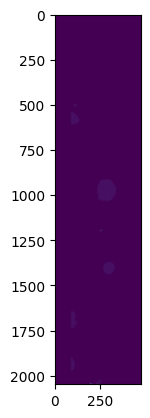

In [27]:
# bboxes, num_cells, cell_areas = bounding_boxes(mask[39])
# bboxes
plt.imshow(mask[4])

### RANDOM figuring shit out

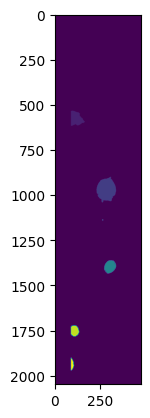

In [9]:
img_temp = img.read_image(C=channel, Z=z_slice_start)
img_temp = scale_img(img_temp[0].squeeze())
test = binarize_video(img_temp)
plt.imshow(test[0])

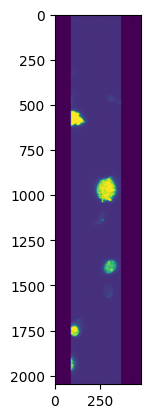

In [44]:
plt.imshow(img_temp[0])

In [4]:
bboxes, num_cells, cell_areas = bounding_boxes(test[0])
bboxes, num_cells, cell_areas

([(534, 88, 619, 166),
  (901, 229, 1043, 338),
  (1363, 272, 1436, 338),
  (1723, 88, 1785, 134),
  (1902, 88, 1973, 105)],
 5,
 array([ 4394., 10685.,  3512.,  2247.,   795.]))

In [5]:
bboxes

[(534, 88, 619, 166),
 (901, 229, 1043, 338),
 (1363, 272, 1436, 338),
 (1723, 88, 1785, 134),
 (1902, 88, 1973, 105)]

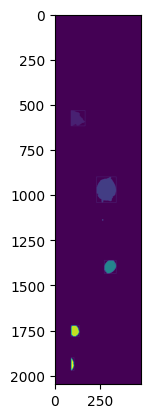

In [7]:
poop = draw_boxes(test[0], bboxes)
plt.imshow(poop)

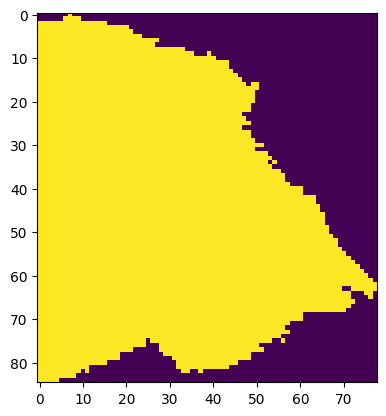

In [14]:
plt.imshow(test[0][534:619,88:166])

In [17]:
k = 0
peepee = np.load(of_address+'/{}.npz'.format(k))

In [18]:
peepee

In [45]:
x = peepee['vx'][0]
y = peepee['vy'][0]

x_masked = x[534:619,88:166] * test[0][534:619,88:166]
y_masked = y[534:619,88:166] * test[0][534:619,88:166]
np.sum(x_masked)

-3036.459937934924

In [37]:
skimage.measure.centroid(test[0][534:619,88:166])

array([45.09080564, 28.87187073])

In [38]:
np.array([45.09080564+534, 28.87187073+88])

array([579.09080564, 116.87187073])

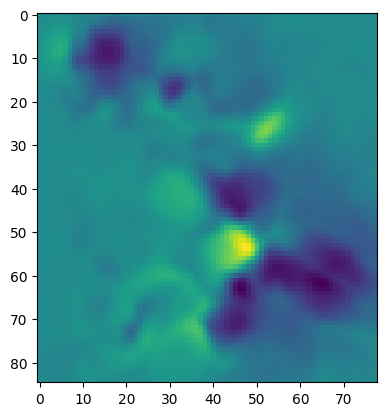

In [40]:
plt.imshow(x[534:619,88:166])


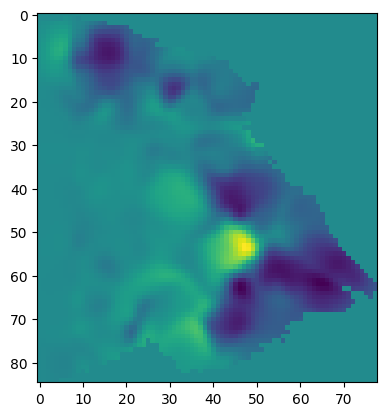

In [42]:
plt.imshow(x_masked)

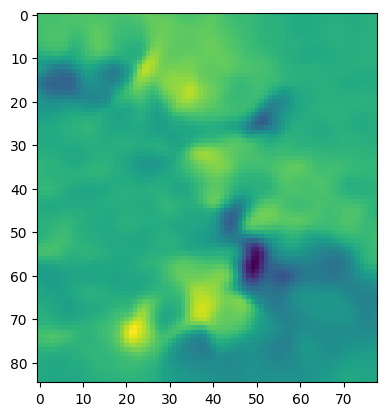

In [46]:
plt.imshow(y[534:619,88:166])

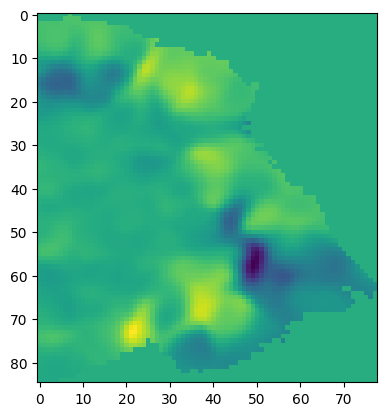

In [47]:
plt.imshow(y_masked)

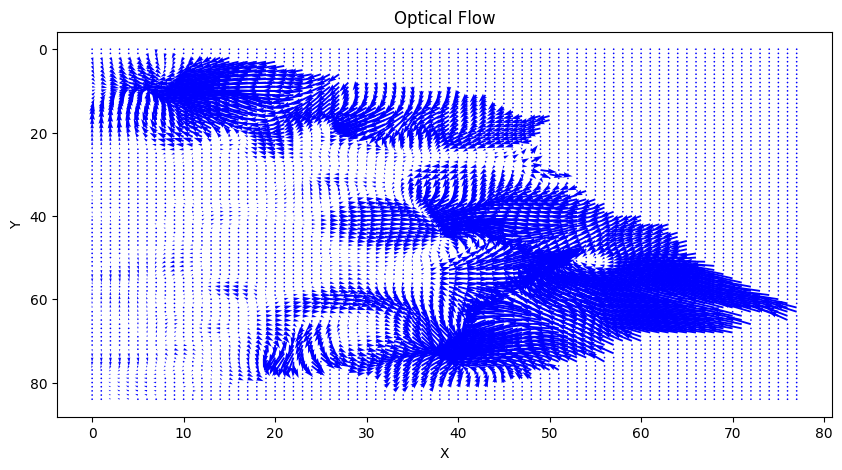

In [48]:
def visualize_optical_flow(flow_x, flow_y):
    # Compute the magnitude and angle of the flow vectors
    magnitude = np.sqrt(flow_x ** 2 + flow_y ** 2)
    angle = np.arctan2(flow_y, flow_x)

    # Create a grid for plotting
    x = np.arange(0, flow_x.shape[1], 1)
    y = np.arange(0, flow_x.shape[0], 1)
    X, Y = np.meshgrid(x, y)

    # Plot the flow field
    plt.figure(figsize=(10, 5))
    plt.quiver(X, Y, flow_x, flow_y, angles='xy', scale_units='xy', scale=1, color='b')
    plt.gca().invert_yaxis()  # Invert y-axis to match the standard image coordinate system
    plt.title('Optical Flow')
    plt.xlabel('X')
    plt.ylabel('Y')
    plt.show()

# Visualize the optical flow
visualize_optical_flow(x_masked, y_masked)

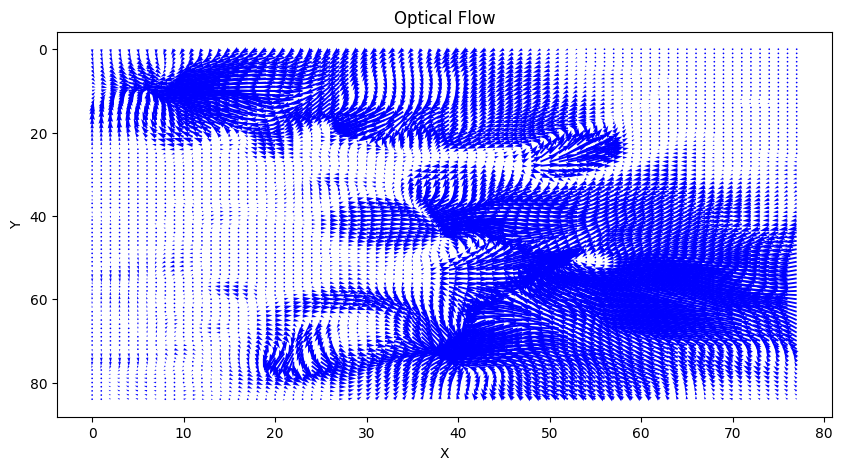

In [49]:
visualize_optical_flow(x[534:619,88:166], y[534:619,88:166])

In [50]:
# Assuming arr is your 2D NumPy array
arr = np.array([[0, 2, 0],
                [3, 0, 4],
                [0, 5, 6]])

# Change all non-zero elements to 1
arr[arr != 0] = 1

print(arr)

[[0 1 0]
 [1 0 1]
 [0 1 1]]


In [75]:
noth = np.array([])
lol = np.array([1,2])
xd = np.array([3,4])
print(np.append(noth, lol))
print(np.append(lol, xd))

[1. 2.]
[1 2 3 4]
